BioGIM VALIDATION

SOB-10 40 mM Thiosulfate Validation

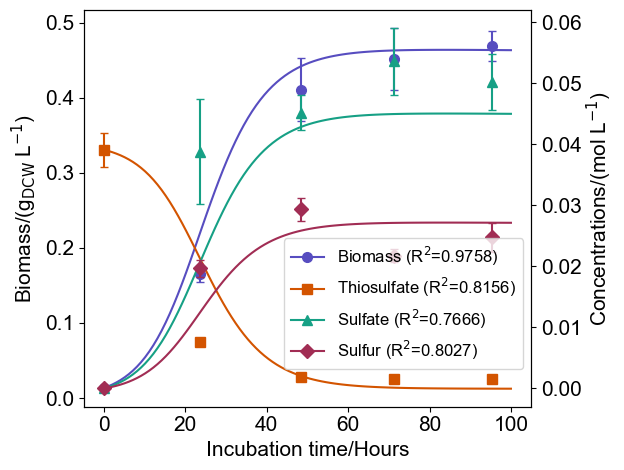

Validation Parameters:
μmax-H = 0.4956 h⁻¹
μmax-true = 0.2188 h⁻¹
Ks = 0.0879 mol/L
Ki = 0.2196 mol/L
k_so = 0.000010 L/g DCW-h
S_max_h = 0.1389 M

Fixed parameters:
Yxs = 11.6  Yps = 1.16  Yp2s = 0.7  Yso4_s0 = 0.0000
Ks_switch = 0.010000  ms = 1e-05  Pso4_max = 0.1258  k = 1.6

R2 values:
Biomass (X): 0.9758
Thiosulfate (S): 0.8156
Sulfate (P_SO4): 0.7666
Sulfur (P_S0): 0.8027

RMSE values:
Biomass (X): 0.0282
Thiosulfate (S): 0.0063
Sulfate (P_SO4): 0.0094
Sulfur (P_S0): 0.0045


In [4]:
# ======== MODEL VALIDATION: SOB-10 40 mM VALIDATION =========

# -------- Import Libraries --------
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.lines import Line2D
from scipy.stats import sem, t

# ===================== LOAD VALIDATION DATASET =====================
# -------- Triplicate Experimental Data --------
t_data = np.array([0.00, 23.50, 48.33, 71.33, 95.25])  # in hours

X_trip = np.array([
    [0.0130, 0.1700, 0.3922, 0.4708, 0.4615],
    [0.0138, 0.1627, 0.4254, 0.4428, 0.4671],
    [0.0135, 0.1627, 0.4145, 0.4414, 0.4775]
])
S_trip = np.array([
    [0.0379, 0.0078, 0.0017, 0.0017, 0.0016],
    [0.0401, 0.0075, 0.0019, 0.0016, 0.0016],
    [0.0393, 0.0075, 0.0018, 0.0016, 0.0016]
])
P_trip = np.array([
    [0.0000, 0.0348, 0.0465, 0.0512, 0.0523],
    [0.0000, 0.0412, 0.0445, 0.0555, 0.0492],
    [0.0000, 0.0403, 0.0445, 0.0541, 0.0491]
])
PS_trip = np.array([
    [0.0000, 0.0191, 0.0302, 0.0214, 0.0259],
    [0.0000, 0.0202, 0.0289, 0.0222, 0.0243],
    [0.0000, 0.0198, 0.0289, 0.0216, 0.0242]
])

# ===================== UTILITY FUNCTIONS =====================
# --- Mean and 95% Confidence Interval ---
def mean_ci(data):
    mean = np.mean(data, axis=0)
    ci = sem(data, axis=0) * t.ppf(0.975, df=data.shape[0]-1)
    return mean, ci

# --- Coefficient of Determination (R²) ---
def calculate_r2(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

# --- Root Mean Square Error (RMSE) ---
def calculate_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted) ** 2))

# ===================== CALCULATE MEANS & ERROR BARS =====================
X_data, X_err = mean_ci(X_trip)
S_data, S_err = mean_ci(S_trip)
P_data, P_err = mean_ci(P_trip)
PS_data, PS_err = mean_ci(PS_trip)

# ===================== MODEL AND KINETIC CALIBRATION PARAMETERS, ALL FIXED =====================
Yxs = 11.6
Yps = 1.16      
Yp2s = 0.7
Yso4_s0 = 0.00000
k = 1.6
Ks_switch = 0.010

u = 0.4956
Ks = 0.08788 
Ki = 0.2196  
Pso4_max = 0.1258
ms = 1e-05
k_so = 1e-05  

# ===================== MODEL DEFINITION =====================
def model(y, t, u, Ks, Ki, Pso4_max, k, ms, k_so):
    X, S, P, Ps = y
    mu = ((u * S) / (Ks + S + ((S**2) / Ki))) * (max(1e-6, 1 - P / Pso4_max) ** k)  #Eq. 10
    dXdt = mu * X                                                                   #Eq. 6
    r_so = k_so * Ps * X if S < Ks_switch else 0                                    #Eq. 17
    dSdt = (dXdt * (-1 / Yxs)) - ms * X                                             #Eq. 14
    dPdt = dXdt * (Yps / Yxs) + Yso4_s0 * r_so                                      #Eq. 15
    dP2dt = dXdt * (Yp2s / Yxs) - r_so                                              #Eq. 16
    return [dXdt, dSdt, dPdt, dP2dt]

# ===================== MODEL SIMULATION =====================
y0 = [X_data[0], S_data[0], P_data[0], PS_data[0]]
t_fine = np.linspace(0, 100, 100)
solution = odeint(model, y0, t_fine, args=(u, Ks, Ki, Pso4_max, k, ms, k_so))
X_fit, S_fit, P_fit, PS_fit = solution.T

# ===================== VALIDATION METRICS (R2 & RMSE) =====================
X_pred = np.interp(t_data, t_fine, X_fit)
S_pred = np.interp(t_data, t_fine, S_fit)
P_pred = np.interp(t_data, t_fine, P_fit)
PS_pred = np.interp(t_data, t_fine, PS_fit)

r2_X = calculate_r2(X_data, X_pred)
r2_S = calculate_r2(S_data, S_pred)
r2_P = calculate_r2(P_data, P_pred)
r2_PS = calculate_r2(PS_data, PS_pred)

rmse_X = calculate_rmse(X_data, X_pred)
rmse_S = calculate_rmse(S_data, S_pred)
rmse_P = calculate_rmse(P_data, P_pred)
rmse_PS = calculate_rmse(PS_data, PS_pred)

# ===================== PLOTTING: MODEL FIT VS DATA =====================
colors = ['#574dc0', '#d35400', '#16a085', '#a12d54']  # [Biomass, S, P, PS]
plt.rcParams['font.family'] = 'Arial'

fig, ax1 = plt.subplots()
marker_size = 7  # Adjust marker size here

# --- Biomass (primary y-axis) ---
ax1.plot(t_fine, X_fit, '-', color=colors[0])
ax1.errorbar(t_data, X_data, yerr=X_err, fmt='o',
             markerfacecolor=colors[0], markeredgecolor=colors[0],
             ecolor=colors[0], capsize=3, markersize=marker_size)
ax1.set_xlabel('Incubation time/Hours', fontsize=15)
ax1.set_ylabel(r'Biomass/(g$_{\mathrm{DCW}}$ L$^{-1}$)', fontsize=15)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)

# --- S, P, PS (secondary y-axis) ---
ax2 = ax1.twinx()
ax2.plot(t_fine, S_fit, '-', color=colors[1])
ax2.errorbar(t_data, S_data, yerr=S_err, fmt='s', markerfacecolor=colors[1], markeredgecolor=colors[1],
             ecolor=colors[1], capsize=3, markersize=marker_size)
ax2.plot(t_fine, P_fit, '-', color=colors[2])
ax2.errorbar(t_data, P_data, yerr=P_err, fmt='^', markerfacecolor=colors[2], markeredgecolor=colors[2],
             ecolor=colors[2], capsize=3, markersize=marker_size)
ax2.plot(t_fine, PS_fit, '-', color=colors[3])
ax2.errorbar(t_data, PS_data, yerr=PS_err, fmt='D',
             markerfacecolor=colors[3], markeredgecolor=colors[3], ecolor=colors[3], capsize=3, markersize=marker_size)

ax2.set_ylabel(r'Concentrations/(mol L$^{-1}$)', color='k', fontsize=15)
ax2.tick_params(axis='y', labelcolor='k', labelsize=15)
ax2.yaxis.set_label_coords(1.12, 0.5)

legend_marker_size = 7
legend_elements = [
    Line2D([0], [0], color=colors[0], marker='o', linestyle='-', label=f'Biomass (R$^2$={r2_X:.4f})',
           markerfacecolor=colors[0], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[1], marker='s', linestyle='-', label=f'Thiosulfate (R$^2$={r2_S:.4f})',
           markerfacecolor=colors[1], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[2], marker='^', linestyle='-', label=f'Sulfate (R$^2$={r2_P:.4f})',
           markerfacecolor=colors[2], markersize=legend_marker_size),
    Line2D([0], [0], color=colors[3], marker='D', linestyle='-', label=f'Sulfur (R$^2$={r2_PS:.4f})',
           markerfacecolor=colors[3], markersize=legend_marker_size)
]

fig.tight_layout()
fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1, 0.26),
           bbox_transform=ax1.transAxes, fontsize=12)


plt.show()

# ===================== DERIVED HALDANE METRICS =====================
umax_true = u / (1 + 2*(Ks/Ki)**0.5)
S_max_h = (Ks * Ki)**0.5

# ===================== PRINT OUTPUT =====================
print("Validation Parameters:")
print(f"μmax-H = {u:.4f} h⁻¹\nμmax-true = {umax_true:.4f} h⁻¹")
print(f"Ks = {Ks:.4f} mol/L\nKi = {Ki:.4f} mol/L\nk_so = {k_so:.6f} L/g DCW-h\nS_max_h = {S_max_h:.4f} M")
print(f"\nFixed parameters:\nYxs = {Yxs}  Yps = {Yps}  Yp2s = {Yp2s}  Yso4_s0 = {Yso4_s0:.4f}")
print(f"Ks_switch = {Ks_switch:.6f}  ms = {ms}  Pso4_max = {Pso4_max}  k = {k}\n")

r2_names = ['Biomass (X)', 'Thiosulfate (S)', 'Sulfate (P_SO4)', 'Sulfur (P_S0)']
r2_vals = [r2_X, r2_S, r2_P, r2_PS]
rmse_vals = [rmse_X, rmse_S, rmse_P, rmse_PS]

print("R2 values:")
for name, val in zip(r2_names, r2_vals):
    print(f"{name}: {val:.4f}")

print("\nRMSE values:")
for name, val in zip(r2_names, rmse_vals):
    print(f"{name}: {val:.4f}")

